In [1]:
import numpy as np
import tensorflow as tf
from pinn import get_network
from pinn.utils import atomic_dress, get_atomic_dress
from ase.collections import g2
from pinn.io import sparse_batch, load_numpy
from docs.notebooks.network_fns import preprocess_traintest_sets, train_and_evaluate_network, _generator, predict_energy
import matplotlib.pyplot as plt
from ase import Atoms
from ase.calculators.lj import LennardJones
import time
from sklearn.metrics import mean_squared_error
import os
from tensorboard.plugins.hparams import api as hp
from pinn.optimizers import get

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
physical_devices = tf.config.list_physical_devices()
tf.config.set_visible_devices(physical_devices[0], 'CPU')
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Helper function: get the position given PES dimension(s)
def three_body_sample(atoms, a, r):
    x = a * np.pi / 180
    pos = [[0, 0, 0],
           [0, 2, 0],
           [0, r*np.cos(x), r*np.sin(x)]]
    atoms.set_positions(pos)
    return atoms

In [4]:
atoms = Atoms('H3', calculator=LennardJones())

na, nr = 50, 50
arange = np.linspace(30,180,na)
rrange = np.linspace(1,3,nr)

# Truth
agrid, rgrid = np.meshgrid(arange, rrange)
egrid = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        atoms = three_body_sample(atoms, arange[i], rrange[j])
        egrid[i,j] = atoms.get_potential_energy()
        
# Samples
nsample = 100
asample, rsample = [], []
distsample = []
data = {'e_data':[], 'f_data':[], 'elems':[], 'coord':[]}
for i in range(nsample):
    a, r = np.random.choice(arange), np.random.choice(rrange)
    atoms = three_body_sample(atoms, a, r)
    dist = atoms.get_all_distances()
    dist = dist[np.nonzero(dist)]
    data['e_data'].append(atoms.get_potential_energy())
    data['f_data'].append(atoms.get_forces())
    data['coord'].append(atoms.get_positions())
    data['elems'].append(atoms.numbers)
    asample.append(a)
    rsample.append(r)
    distsample.append(dist)

### Dataset from numpy arrays

In [5]:
data = {k:np.array(v) for k,v in data.items()}
print("e_data shape: ", data['e_data'].shape)
print("f_data shape: ", data['f_data'].shape)
print("coord shape: ", data['coord'].shape)
print("elems shape: ", data['elems'].shape)

dataset = load_numpy(data, splits={'train':8, 'test':2})
dress, error = get_atomic_dress(dataset['train'], [1])
# train_set, test_set, batch_size = get_traintest_sets(dataset, buffer_size=100, batch_size=10)

e_data shape:  (100,)
f_data shape:  (100, 3, 3)
coord shape:  (100, 3, 3)
elems shape:  (100, 3)


2023-03-29 23:14:59.095863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-29 23:14:59.095978: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
batch_size = 100
train_repeats = 2000

def print_shapes(batch):
    print("ind_1 shape: ", batch['ind_1'].shape)
    print("e_data shape: ", batch['e_data'].shape)
    print("f_data shape: ", batch['f_data'].shape)
    print("elems shape: ", batch['elems'].shape)
    print("coord shape: ", batch['coord'].shape)
    return batch

# train_set = dataset['train'].shuffle(100).repeat(train_repeats).apply(sparse_batch(batch_size)).map(print_shapes)
# test_set = dataset['test'].repeat(100).apply(sparse_batch(100)).map(print_shapes)

train_set = dataset['train'].shuffle(100).repeat(train_repeats).apply(sparse_batch(batch_size))
test_set = dataset['test'].repeat(100).apply(sparse_batch(100))

In [7]:
train_set

<ParallelMapDataset shapes: {e_data: (None,), f_data: (None, 3), elems: (None,), coord: (None, 3), ind_1: (None, 1)}, types: {e_data: tf.float32, f_data: tf.float32, elems: tf.int32, coord: tf.float32, ind_1: tf.int32}>

### Get network and preprocess data

In [8]:
params={
    'optimizer': {
        'class_name': 'Adam',
        'config': {
            'learning_rate': {
                'class_name': 'ExponentialDecay',
                'config': {
                    'initial_learning_rate': 0.0003,
                    'decay_steps': 10000, 
                    'decay_rate': 0.994}}, 
                    'clipnorm': 0.01}},
    'network': {
        'name': 'PiNet',
        'params': {
            'ii_nodes':[8,8],
            'pi_nodes':[8,8],
            'pp_nodes':[8,8],
            'out_nodes':[8,8],
            'depth': 4,
            'rc': 3.0,
            'atom_types':[1]}},

    'e_dress': dress,  # element-specific energy dress
    'e_scale': 2, # energy scale for prediction
    'e_unit': 1.0,  # output unit of energy dur
    'use_force': True
} 


In [9]:
def print_preprocessed_shapes(batch, counter=[0]):
    counter[0] += 1
    print(f"=== Batch {counter[0]} ===")
    for key, value in batch.items():
        print(f"{key} shape: {value.shape}")
    return batch

In [10]:
network = get_network(params['network'])

In [11]:
preprocess_traintest_sets(train_set, test_set, network=network)

### Training

In [12]:
def train_and_evaluate_network(network=None, params=None, train_set=None, test_set=None, batch_size=256, epochs=1):


    # Instantiate an optimizer
    from pinn.optimizers import get
    optimizer = get(params['optimizer'])
    # Define a loss function
    loss_fn = tf.keras.losses.mse
    validation_losses = []

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time_epoch = time.time()
        hund_step_times = []


        # Iterate over the batches of the dataset.
        for step, batch in enumerate(train_set):
            # print('starting step', step)
            train_losses = []
            train_MAEs = []
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as loss_tape:
                with tf.GradientTape() as innertape:
                    innertape.watch(batch)

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.

                    pred = network(batch, training=True)  # Logits for this minibatch
                    # print("pred shape: ", pred.shape)

                    ind = batch['ind_1']
                    nbatch = tf.reduce_max(ind)+1
                    pred = tf.math.unsorted_segment_sum(pred, ind[:, 0], nbatch)    
                    e_data = batch['e_data']

                    if params['e_dress']:
                        e_data -= atomic_dress(batch, params['e_dress'], dtype=pred.dtype)
                    e_data *= params['e_scale']
                    
                    # print("pred shape after unsorted_segment_sum:", pred.shape)
                    # print("e_data shape:", e_data.shape)
                
                    train_losses.append(loss_fn(e_data, pred))
                    train_MAEs.append(tf.reduce_mean(np.abs(e_data - pred)))


                if params['use_force']:

                    f_pred = innertape.gradient(pred, batch['coord'])
                    if type(f_pred) == tf.IndexedSlices:
                        f_pred = tf.scatter_nd(tf.expand_dims(f_pred.indices, 1), f_pred.values,
                                            tf.cast(f_pred.dense_shape, tf.int32))

                    f_pred = -f_pred

                    f_data = batch['f_data']*params['e_scale']
                    f_mask = tf.fill(tf.shape(f_pred), True)

                    error = f_data - f_pred
                    error = tf.boolean_mask(error, f_mask)
                    # print("f_data shape: ", f_data.shape)
                    # print("f_pred shape after scatter_nd and negate:", f_pred.shape)
                    train_losses.append(tf.reduce_mean(error**2))
                    train_MAEs.append(tf.reduce_mean(error))

                # Compute the loss value for this minibatch.
                train_loss_value = tf.reduce_sum(train_losses)
                train_MAE_value = tf.reduce_sum(train_MAEs)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = loss_tape.gradient(train_loss_value, network.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, network.trainable_weights))



            # Log every n batches.
            if step == 0:
                print(f"Initial loss (for one batch): {float(train_loss_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")


            elif step % 20 == 0:
                print(f"Training loss (for one batch) at step {step}: {float(train_loss_value)}")
                print(f"Training MAE (for one batch) at step {step}: {float(train_MAE_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")
                hund_step_times += [(time.time() - start_time_epoch)]
                print(f'Training time for 20 batches: {((hund_step_times[-1] - hund_step_times[-2]) if len(hund_step_times) > 1 else hund_step_times[-1])} s')


        print(f'Training time for epoch {epoch + 1}: {(time.time() - start_time_epoch)} s')

        

        # Run a validation loop at the end of each epoch
        print(f'Starting validation for epoch {(epoch + 1)}')

        for step, batch in enumerate(test_set):

            val_losses = []
            val_MAEs = []
            
            val_pred = network(batch, training=False)
            ind = batch['ind_1']
            nbatch = tf.reduce_max(ind)+1
            val_pred = tf.math.unsorted_segment_sum(val_pred, ind[:, 0], nbatch)
            e_data = batch['e_data']
            
            if params['e_dress']:
                e_data -= atomic_dress(batch, params['e_dress'], dtype=pred.dtype)
                e_data *= params['e_scale']


            val_losses.append(loss_fn(batch['e_data'], val_pred))
            val_MAEs.append(np.abs(e_data - val_pred))

            val_loss_value = tf.reduce_sum(val_losses)
            val_MAE_value = tf.reduce_sum(val_MAEs)
            validation_losses.append(val_loss_value)

            # Log every n batches.
            if step == 0:
                print(f"Initial validation loss (for one batch): {float(val_loss_value)}")
                print(f"Initial validation MAE (for one batch): {float(val_MAE_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")


            elif step % 20 == 0:
                print(f"Validation loss (for one batch) at step {step}: {float(val_loss_value)}")
                print(f"Validation loss (for one batch) at step {step}: {float(val_MAE_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")
                hund_step_times += [(time.time() - start_time_epoch)]
                print(f'Validation time for 20 batches: {((hund_step_times[-1] - hund_step_times[-2]) if len(hund_step_times) > 1 else hund_step_times[-1])} s')

            if epoch > 3 and val_loss_value >= min(validation_losses[-4:-1]):
                        return 'Stopped.'



        print(f"Time taken for epoch {epoch + 1}: {(time.time() - start_time_epoch)} s")



In [13]:
while True:
    try:
        train_and_evaluate_network(network=network, params=params, train_set=train_set, test_set=test_set, batch_size = batch_size, epochs=500)

            
        break

    except tf.errors.InvalidArgumentError:
        print('Raised an error')



Start of epoch 0
Initial loss (for one batch): 7.215100288391113
Seen so far: 100 molecules
Training loss (for one batch) at step 20: 6.3925251960754395
Training MAE (for one batch) at step 20: 0.41383400559425354
Seen so far: 2100 molecules
Training time for 20 batches: 1.0946218967437744 s
Training loss (for one batch) at step 40: 5.961619853973389
Training MAE (for one batch) at step 40: 0.3325004577636719
Seen so far: 4100 molecules
Training time for 20 batches: 0.837688684463501 s
Training loss (for one batch) at step 60: 4.676161766052246
Training MAE (for one batch) at step 60: 0.32789310812950134
Seen so far: 6100 molecules
Training time for 20 batches: 0.828819990158081 s
Training loss (for one batch) at step 80: 2.875715970993042
Training MAE (for one batch) at step 80: 0.3272826075553894
Seen so far: 8100 molecules
Training time for 20 batches: 0.8315722942352295 s
Training loss (for one batch) at step 100: 1.8006536960601807
Training MAE (for one batch) at step 100: 0.2332

8, 8, 0.0003 gave mse of 0.34 for LJ data \
8, 4, 0.0003 with patience 3 and train repeats 100 gave mse of 0.20 \
8, 4, 0.0003 with patience 2 gave 0.22 \
8, 4, 0.0003 with patience 3 and train repeats 50 gave 0.31 \
8, 4, 0.0003 with patience 5 and train repeats 50 gave 0.28 \
8, 8, 0.0003 with patience 3 and train repeats 100 gave 0.24 \
8, 4, 0.0003 with patience 3 and train repeats 80 gave 0.23
8, 4, 0.0003 with patience 3 and train repeats 500 gave

### Pairwise potential analysis

In [14]:
def predict_energy(molecule, network=None, params=None):
        '''Takes an ASE Atoms object and outputs PiNet's energy prediction'''
        dtype=tf.float32
        dtypes = {'coord': dtype, 'elems': tf.int32, 'ind_1': tf.int32}
        shapes = {'coord': [None, 3], 'elems': [None], 'ind_1': [None, 1]}

        pred_dataset = tf.data.Dataset.from_generator(lambda:_generator(molecule), dtypes, shapes)

        for molecule in pred_dataset:
                molecule = network.preprocess(molecule)
                pred = network(molecule, training=False)
                ind = molecule['ind_1']
                nbatch = tf.reduce_max(ind)+1
                pred = pred/params['e_scale']
                if params['e_dress']:
                        pred += atomic_dress(molecule, params['e_dress'], dtype=pred.dtype)
                energy_prediction = tf.math.unsorted_segment_sum(pred, ind[:, 0], nbatch)
                energy_prediction_numpy = energy_prediction.numpy()[0]
        return energy_prediction_numpy


In [15]:
atoms1 = Atoms('H2')
atoms2 = Atoms('H2', calculator=LennardJones())

nr2 = 100
rrange2 = np.linspace(1,1.9,nr2)
epred = np.zeros(nr2)
etrue = np.zeros(nr2)

for i in range(nr2):
    pos = [[0, 0, 0],
           [rrange2[i], 0, 0]]
    atoms1.set_positions(pos)
    atoms2.set_positions(pos)
    epred[i] = predict_energy(atoms1, network=network, params=params)
    etrue[i] = atoms2.get_potential_energy()

Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)
Wrong shape! (2, 1)


In [16]:
# Predictions obtained from the example script using the estimator workflow
estimator_epred = np.array([ 0.53924155,  0.53924155,  0.31333005,  0.10093462, -0.09251928,
       -0.26339132, -0.41004729, -0.53268594, -0.63286495, -0.71293688,
       -0.77557099, -0.82340288, -0.85883415, -0.88394475, -0.90048921,
       -0.90992886, -0.91347712, -0.91214544, -0.9067837 , -0.89810729,
       -0.88672489, -0.87315392, -0.85783267, -0.84113717, -0.82338399,
       -0.80484247, -0.78574157, -0.76627159, -0.74659473, -0.72684616,
       -0.70713782, -0.68756211, -0.66819561, -0.64909941, -0.63032281,
       -0.61190391, -0.59387207, -0.57624871, -0.55904883, -0.54228193,
       -0.52595168, -0.51005912, -0.49460107, -0.47957283, -0.46496773,
       -0.4507778 , -0.43699384, -0.42360735, -0.41060773, -0.39798641,
       -0.3857336 , -0.37384129, -0.36230105, -0.35110471, -0.34024522,
       -0.32971513, -0.31950843, -0.3096177 , -0.300037  , -0.29075974,
       -0.28178009, -0.27309084, -0.26468596, -0.25655863, -0.24870205,
       -0.24110949, -0.23377317, -0.22668669, -0.21984196, -0.21323186,
       -0.20684901, -0.20068565, -0.19473439, -0.18898779, -0.18343845,
       -0.17807949, -0.17290318, -0.16790283, -0.16307196, -0.15840358,
       -0.1538918 , -0.14953002, -0.1453124 , -0.1412335 , -0.13728777,
       -0.13346991, -0.12977493, -0.12619817, -0.12273505, -0.1161325 ,
       -0.11298513, -0.11298513, -0.10993543, -0.10993543, -0.10697967,
       -0.10411453, -0.10133681, -0.09864366, -0.09603179, -0.09349895])

In [17]:
mse_tf2 = mean_squared_error(etrue, epred, squared=False)
mse_estimator = mean_squared_error(etrue, estimator_epred, squared=False)
print(f'Mean squared error when using estimator workflow = {mse_estimator}')
print(f'Mean squared error when using the updated TF2 workflow = {mse_tf2}')


Mean squared error when using estimator workflow = 0.16164043922153268
Mean squared error when using the updated TF2 workflow = 0.24677919941119852


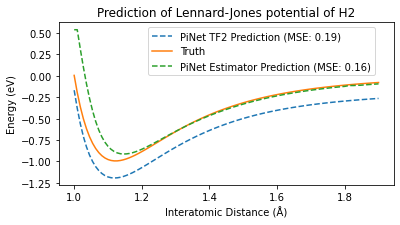

In [19]:
f, ax1 = plt.subplots(figsize = (6,3))
ax1.plot(rrange2, epred, '--')
ax1.plot(rrange2, etrue)
ax1.plot(rrange2, estimator_epred, '--')
ax1.legend([f'PiNet TF2 Prediction (MSE:{mse_tf2: .2f})', 'Truth', f'PiNet Estimator Prediction (MSE:{mse_estimator: .2f})'], loc=2, bbox_to_anchor=(0.25,1))
plt.title('Prediction of Lennard-Jones potential of H2')
ax1.set_xlabel('Interatomic Distance (Å)')
ax1.set_ylabel('Energy (eV)')

output_directory = '/Users/miguelnavaharris/Project/Plots'
output_filename = 'LJ_potential_100batch_1000repeats_8_4_3.png'
output_path = os.path.join(output_directory, output_filename)
plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
epred

array([-0.1676805 , -0.37880796, -0.55995417, -0.70940012, -0.82997358,
       -0.92606837, -1.00197017, -1.06128728, -1.10686541, -1.14094698,
       -1.16531432, -1.18143547, -1.19053948, -1.19368386, -1.19178522,
       -1.1856463 , -1.17596436, -1.16335118, -1.14833665, -1.13138032,
       -1.11287689, -1.09316468, -1.07253528, -1.05123377, -1.02947068,
       -1.00742102, -0.98523283, -0.96303141, -0.94092137, -0.9189868 ,
       -0.89729983, -0.87591875, -0.85489112, -0.83425516, -0.81403977,
       -0.79426932, -0.77496165, -0.75613052, -0.73778361, -0.71992779,
       -0.70256466, -0.68569446, -0.6693157 , -0.65342361, -0.63801467,
       -0.62308121, -0.60861731, -0.59461331, -0.58106101, -0.56795126,
       -0.55527419, -0.54301953, -0.53117621, -0.51973486, -0.50868303,
       -0.49801177, -0.48770872, -0.47776422, -0.46816608, -0.45890489,
       -0.44996932, -0.44134846, -0.43303287, -0.42501166, -0.41727552,
       -0.4098137 , -0.40261737, -0.39567596, -0.38898137, -0.38

In [16]:

def _get_lj_data():
    from ase.calculators.lj import LennardJones

    atoms = Atoms('H3', positions=[[0, 0, 0], [0, 1, 0], [1, 1, 0]])
    atoms.set_calculator(LennardJones(rc=5.0))
    coord, elems, e_data, f_data = [], [], [], []
    for x_a in np.linspace(-5, 0, 1000):
        atoms.positions[0, 0] = x_a
        coord.append(atoms.positions.copy())
        elems.append(atoms.numbers)
        e_data.append(atoms.get_potential_energy())
        f_data.append(atoms.get_forces())

    data = {
        'coord': np.array(coord),
        'elems': np.array(elems),
        'e_data': np.array(e_data),
        'f_data': np.array(f_data)
    }
    return data


# Hyperparameter search

In [3]:
def get_and_train_network(hparams):

    network = get_network(params['network'])
    preprocess_traintest_sets(train_set, test_set, network=network)

    #Set up tensorboard directory and writer
    nodes = hparams[HP_NUM_NODES]
    depth = hparams[HP_DEPTH]
    lr = hparams[HP_LR]

    run_dir = (
    "/Users/miguelnavaharris/Project/hparams_logs/LJ_hparams/"
    + str(nodes)
    + "nodes_"
    + str(depth)
    + "depth_"
    + str(lr)
    + "lr"
    )

    run_dir_writer = tf.summary.create_file_writer(run_dir)

    # Instantiate an optimizer    
    optimizer = get(params['optimizer'])
    # Define a loss function
    loss_fn = tf.keras.losses.mse
    

    for epoch in range(1):
        print("\nStart of epoch %d" % (epoch,))
        start_time_epoch = time.time()
        hund_step_times = []

        print(nodes, depth, lr)
        print(network.depth)

        # Iterate over the batches of the dataset.
        for step, batch in enumerate(train_set):
            # print('starting step', step)
            train_losses = []
            train_MAEs = []
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as loss_tape:
                with tf.GradientTape() as innertape:
                    innertape.watch(batch)

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.

                    pred = network(batch, training=True)  # Logits for this minibatch
                    # print("pred shape: ", pred.shape)

                    ind = batch['ind_1']
                    nbatch = tf.reduce_max(ind)+1
                    pred = tf.math.unsorted_segment_sum(pred, ind[:, 0], nbatch)    
                    e_data = batch['e_data']

                    if params['e_dress']:
                        e_data -= atomic_dress(batch, params['e_dress'], dtype=pred.dtype)
                    e_data *= params['e_scale']
                    
                    # print("pred shape after unsorted_segment_sum:", pred.shape)
                    # print("e_data shape:", e_data.shape)
                
                    train_losses.append(loss_fn(e_data, pred))
                    train_MAEs.append(tf.reduce_mean(np.abs(e_data - pred)))


                if params['use_force']:

                    f_pred = innertape.gradient(pred, batch['coord'])
                    if type(f_pred) == tf.IndexedSlices:
                        f_pred = tf.scatter_nd(tf.expand_dims(f_pred.indices, 1), f_pred.values,
                                            tf.cast(f_pred.dense_shape, tf.int32))

                    f_pred = -f_pred

                    f_data = batch['f_data']*params['e_scale']
                    f_mask = tf.fill(tf.shape(f_pred), True)

                    error = f_data - f_pred
                    error = tf.boolean_mask(error, f_mask)
                    # print("f_data shape: ", f_data.shape)
                    # print("f_pred shape after scatter_nd and negate:", f_pred.shape)
                    train_losses.append(tf.reduce_mean(error**2))
                    train_MAEs.append(tf.reduce_mean(error))


                # Compute the loss value for this minibatch.
                train_loss_value = tf.reduce_sum(train_losses)
                train_MAE_value = tf.reduce_sum(train_MAEs)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = loss_tape.gradient(train_loss_value, network.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, network.trainable_weights))



            # Log every n batches.
            if step == 0:
                print(f"Initial loss (for one batch): {float(train_loss_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")


            elif step % 20 == 0:
                print(f"Training loss (for one batch) at step {step}: {float(train_loss_value)}")
                print(f"Training MAE (for one batch) at step {step}: {float(train_MAE_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")
                hund_step_times += [(time.time() - start_time_epoch)]
                print(f'Training time for 20 batches: {((hund_step_times[-1] - hund_step_times[-2]) if len(hund_step_times) > 1 else hund_step_times[-1])} s')

                # Record TensorBoard metrics
                with run_dir_writer.as_default():
                    print('Writing to tb')
                    tf.summary.scalar('Training loss', train_loss_value, step=step)
                    tf.summary.scalar('Training MAE', train_MAE_value, step=step)


        print(f'Training time for epoch {epoch + 1}: {(time.time() - start_time_epoch)} s')

        

        # Run a validation loop at the end of each epoch
        print(f'Starting validation for epoch {(epoch + 1)}')

        for step, batch in enumerate(test_set):

            val_losses = []
            val_MAEs = []
            
            val_pred = network(batch, training=False)
            ind = batch['ind_1']
            nbatch = tf.reduce_max(ind)+1
            val_pred = tf.math.unsorted_segment_sum(val_pred, ind[:, 0], nbatch)
            e_data = batch['e_data']

            if params['e_dress']:
                e_data -= atomic_dress(batch, params['e_dress'], dtype=pred.dtype)
                e_data *= params['e_scale']

            val_losses.append(loss_fn(e_data, val_pred))
            val_MAEs.append(np.abs(e_data - val_pred))


            val_loss_value = tf.reduce_sum(val_losses)
            val_MAE_value = tf.reduce_sum(val_MAEs)

            # Record TensorBoard metrics
            with run_dir_writer.as_default():
                print('Writing to tb')
                tf.summary.scalar('Validation loss', val_loss_value, step=step)
                tf.summary.scalar('Validation MAE', val_MAE_value, step=step)
            


            # Log every n batches.
            if step == 0:
                print(f"Initial validation loss (for one batch): {float(val_loss_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")


            elif step % 20 == 0:
                print(f"Validation loss (for one batch) at step {step}: {float(val_loss_value)}")
                print(f"Seen so far: {((step + 1) * batch_size)} molecules")
                hund_step_times += [(time.time() - start_time_epoch)]
                print(f'Validation time for 20 batches: {((hund_step_times[-1] - hund_step_times[-2]) if len(hund_step_times) > 1 else hund_step_times[-1])} s')

        with run_dir_writer.as_default():
            hp.hparams(hparams)
            tf.summary.scalar("Training error", train_MAE_value, step=1)
            tf.summary.scalar("Validation error", val_MAE_value, step=1)
            tf.summary.scalar("Training loss", train_loss_value, step=1)
            tf.summary.scalar("Validation loss", val_loss_value, step=1)


        print(f"Time taken for epoch {epoch + 1}: {(time.time() - start_time_epoch)} s")



In [4]:
HP_NUM_NODES = hp.HParam("num nodes", hp.Discrete([8, 16, 32]))
HP_DEPTH = hp.HParam("depth", hp.Discrete([4, 8, 16]))
HP_LR = hp.HParam("initial learning rate", hp.Discrete([0.0003, 0.01, 0.03]))


error_count = 0
while True:
    try:


        def three_body_sample(atoms, a, r):
            x = a * np.pi / 180
            pos = [[0, 0, 0],
                [0, 2, 0],
                [0, r*np.cos(x), r*np.sin(x)]]
            atoms.set_positions(pos)
            return atoms

        atoms = Atoms('H3', calculator=LennardJones())

        na, nr = 50, 50
        arange = np.linspace(30,180,na)
        rrange = np.linspace(1,3,nr)

        # Truth
        agrid, rgrid = np.meshgrid(arange, rrange)
        egrid = np.zeros([na, nr])
        for i in range(na):
            for j in range(nr):
                atoms = three_body_sample(atoms, arange[i], rrange[j])
                egrid[i,j] = atoms.get_potential_energy()
        
        # Samples
        nsample = 100
        asample, rsample = [], []
        distsample = []
        data = {'e_data':[], 'f_data':[], 'elems':[], 'coord':[]}
        for i in range(nsample):
            a, r = np.random.choice(arange), np.random.choice(rrange)
            atoms = three_body_sample(atoms, a, r)
            dist = atoms.get_all_distances()
            dist = dist[np.nonzero(dist)]
            data['e_data'].append(atoms.get_potential_energy())
            data['f_data'].append(atoms.get_forces())
            data['coord'].append(atoms.get_positions())
            data['elems'].append(atoms.numbers)
            asample.append(a)
            rsample.append(r)
            distsample.append(dist)

        data = {k:np.array(v) for k,v in data.items()}
        dataset = load_numpy(data, splits={'train':8, 'test':2})
        dress, error = get_atomic_dress(dataset['train'], [1])

        batch_size = 100
        train_repeats = 1000
        train_set = dataset['train'].shuffle(100).repeat(train_repeats).apply(sparse_batch(batch_size))
        test_set = dataset['test'].repeat(100).apply(sparse_batch(100))

        
        for num_nodes in HP_NUM_NODES.domain.values:
            for depth in HP_DEPTH.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                        HP_NUM_NODES: num_nodes,
                        HP_DEPTH: depth,
                        HP_LR: lr
                    }
                    
                    params={
                        'optimizer': {
                            'class_name': 'Adam',
                            'config': {
                                'learning_rate': {
                                    'class_name': 'ExponentialDecay',
                                    'config': {
                                        'initial_learning_rate': lr,
                                        'decay_steps': 10000, 
                                        'decay_rate': 0.994}}, 
                                        'clipnorm': 0.01}},
                        'network': {
                            'name': 'PiNet',
                            'params': {
                                'ii_nodes':[num_nodes,num_nodes],
                                'pi_nodes':[num_nodes,num_nodes],
                                'pp_nodes':[num_nodes,num_nodes],
                                'out_nodes':[num_nodes,num_nodes],
                                'depth': depth,
                                'rc': 3.0,
                                'atom_types':[1]}},

                        'e_dress': dress,
                        'e_scale': 2,
                        'e_unit': 1.0,
                        'use_force': True
                    } 
            
                    get_and_train_network(hparams)

            break
    except tf.errors.InvalidArgumentError:
        print('Raised an error')
        error_count += 1


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-29 14:09:36.154501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-29 14:09:36.154598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-29 14:09:36.188040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-29 14:09:36.188198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Start of epoch 0
8 4 0.0003
4
Initial loss (for one batch): 37.69180679321289
Seen so far: 100 molecules
Training loss (for one batch) at step 20: 28.057342529296875
Training MAE (for one batch) at step 20: 0.6172356605529785
Seen so far: 2100 molecules
Training time for 20 batches: 7.19642186164856 s
Writing to tb
Training loss (for one batch) at step 40: 26.139341354370117
Training MAE (for one batch) at step 40: 0.6227275133132935
Seen so far: 4100 molecules
Training time for 20 batches: 7.249698162078857 s
Writing to tb
Wrong shape! (299, 1)
Raised an error

Start of epoch 0
8 4 0.0003
4
Initial loss (for one batch): 24.42711067199707
Seen so far: 100 molecules
Wrong shape! (299, 1)
Raised an error

Start of epoch 0
8 4 0.0003
4
Initial loss (for one batch): 31.165027618408203
Seen so far: 100 molecules
Training loss (for one batch) at step 20: 17.50162124633789
Training MAE (for one batch) at step 20: 0.5736317038536072
Seen so far: 2100 molecules
Training time for 20 batches: 7.

KeyboardInterrupt: 